# Hodgkin-Huxley, close to threshold

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils, stim_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

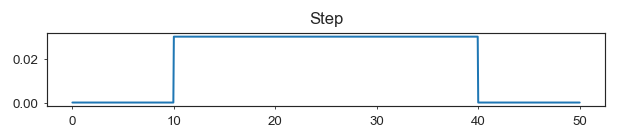

In [6]:
t0, tmax = 0, 50
stim_onset, stim_offset = 10, tmax-10
stim = stim_utils.IStimStep(Iamp=0.03, onset=stim_onset, offset=stim_offset, name='Step')
stim.plot(t0=t0, tmax=tmax)

neuron.get_Istim_at_t = stim.get_I_at_t

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
    
gen = DataGeneratorHH(
    t0=t0, tmax=tmax,
    return_vars=['events', 'ys'],
    model=neuron, y0=neuron.compute_yinf(-65), thresh=0.0,
    n_samples=100, n_parallel=20,
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=False,
    base_folder='data'
)
gen.update_subfoldername(stim=stim.name)
gen.load_acc_sols_from_file()    

## Data

In [8]:
neuron.get_Istim_at_t(stim_onset)

0.03

0.02241


  0%|          | t=0.00000/50=tmax [00:00<?]

2 times the following warning: inefficient


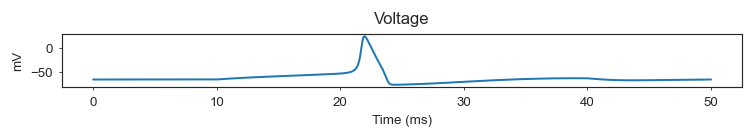

0.022406


  0%|          | t=0.00000/50=tmax [00:00<?]

1 times the following warning: inefficient


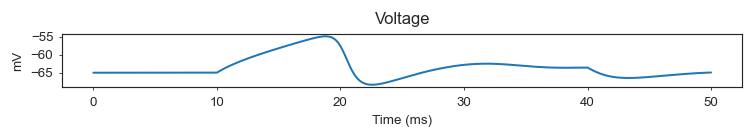

ODE_solution(ts=0.0-50.0)

In [9]:
stim.Iamp = 0.02241
print(neuron.get_Istim_at_t(stim_onset))
gen.gen_acc_sol(t_eval=None, plot=True)

stim.Iamp = 0.022406
print(neuron.get_Istim_at_t(stim_onset))
gen.gen_acc_sol(t_eval=None, plot=True)

In [10]:
# pert_method, adaptive, methods, step_params, pert_param
solver_params = [('conrad', 1, ['RKDP'], [1e-3, 1e-5, 1e-7])]

In [11]:
np.random.seed(42)
   
stim.Iamp = 0.022406
print(neuron.get_Istim_at_t(stim_onset))
gen.acc_sols = []
    
for pert_method, adaptive, methods, step_params in solver_params:
    for step_param, method in itproduct(step_params, methods):
        gen.gen_and_save_data(
            method=method, adaptive=adaptive, step_param=step_param,
            pert_method=pert_method, overwrite=True, allowgenerror=False,
        )

0.022406
                                 RKDP_a(0.001)_conrad(1).pkl --> Generate data because overwrite==True.
No acc_sol found. Create reference solution!
1 times the following warning: inefficient
                                 RKDP_a(1e-05)_conrad(1).pkl --> Generate data because overwrite==True.
                                 RKDP_a(1e-07)_conrad(1).pkl --> Generate data because overwrite==True.
89 times the following warning: inefficient
1 times the following warning: inefficient


# Load data

In [12]:
from neuroprobnum.generator.dataloader import DataLoader

df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
df['stimfun'] = stim
df['stim'] = stim.name

In [13]:
df['n_spikes_acc'] = df.acc_events.apply(lambda x: len(x[0]))
df['n_spikes_acc']

0    0
1    0
2    0
Name: n_spikes_acc, dtype: int64

In [14]:
df['n_spikes_det'] = df.det_events.apply(lambda x: len(x[0]))
df['n_spikes_det']

0    1
1    1
2    0
Name: n_spikes_det, dtype: int64

In [15]:
df['n_spikes'] = df.events.apply(lambda x: [len(xi[0]) for xi in x])
df['n_spikes']

0    [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, ...
1    [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: n_spikes, dtype: object

# Plot

In [16]:
df.columns

Index(['acc_events', 'acc_ts', 'acc_vs', 'adaptive', 'det_events',
       'det_nODEcalls', 'det_run_time', 'det_ts', 'det_vs', 'events', 'method',
       'nODEcalls', 'n_samples', 'pert_method', 'pert_param', 'run_times',
       'seed', 'step_param', 't0', 'tmax', 'ts', 'vs', 'stimfun', 'stim',
       'n_spikes_acc', 'n_spikes_det', 'n_spikes'],
      dtype='object')

In [17]:
def plot_n_spikes(ax, data_rows):
    """Plot number of spikes for different solver settings"""
    xticklabels = []
    for i, (_, row) in enumerate(data_rows.iterrows()):
        zero_spikes = (np.array(row.n_spikes) == 0).astype(int)
        ax.bar(i, np.mean(zero_spikes), yerr=np.std(zero_spikes, ddof=1)/np.sqrt(row.n_samples), color='C0')
        xticklabels.append(pltu.step_param2tick(step_param=row.step_param, adaptive=1))
    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.set(xlabel="κ", ylabel='Fraction of samples\nwith zero spikes', ylim=(0, 1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [18]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs, plot_events

def plot_row(axs, data, nraster=10):
    
    assert axs.size == 4, axs.size
    
    stim_ts = np.arange(t0, tmax, 0.01)
    plot_stim(ax=axs[0], ts=stim_ts, stim=[data.stimfun.get_I_at_t(t=t) for t in stim_ts])
    plot_vs(ax=axs[1], ts=data.acc_ts, vs=data.acc_vs, c='k')
    plot_vs(ax=axs[2], ts=data.det_ts, vs=data.det_vs, c='C1')
    
    plot_events(ax=axs[3], events=data.events[:nraster], event_traces={'det.': (data.det_events[0], 'C1'), 'ref.': (data.acc_events[0], 'k')})
    
    pltu.make_share_xlims(axs)
    for ax in axs[:-1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

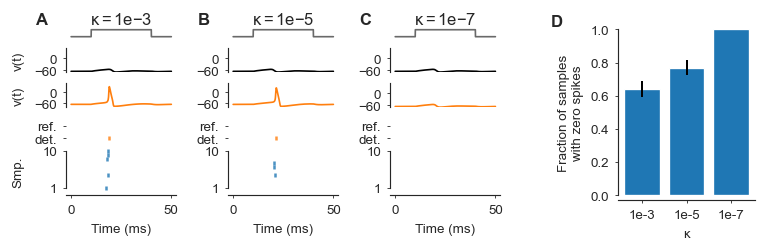

In [20]:
rows_per_mode = 4
num_rows = 1
num_cols = 3

assert num_rows * num_cols == df.shape[0]

fig, axs = pltu.subplots(num_cols, rows_per_mode*num_rows, ysizerow=0.43, yoffsize=0.3, xsize='fullwidth', squeeze=False, gridspec_kw=dict(
    height_ratios=([0.08] + [0.25]*int(rows_per_mode-2) + [0.8])*num_rows))

despine()

for i, (_, row) in enumerate(df.iterrows()):
    if i*rows_per_mode >= axs.size:
        break
    axs_set = axs[int(i/num_cols)*rows_per_mode:(int(i/num_cols)+1)*rows_per_mode, i%num_cols]
    plot_row(axs=axs_set, data=row)
    axs_set[0].set_title(pltu.step_param2label(step_param=row.step_param, adaptive=1), va='bottom', y=1.3)
    
for ax in axs[:, 1:].flat:
    ax.set_ylabel(None)
    
# Adjust spacing
mode_spacing = 0.085
plt.tight_layout(h_pad=-2.5 if num_rows > 1 else 0.1, rect=[0, (num_rows-1)*mode_spacing, 0.65, 1], pad=0.3, w_pad=1.5)
for i in range(num_rows):
    pltu.move_box(axs[i*rows_per_mode:(i+1)*rows_per_mode], dy=-mode_spacing*i)
    
pltu.set_labs(axs[np.arange(0, num_rows)*rows_per_mode, :], panel_nums='auto', panel_num_space=4, panel_num_va='bottom', panel_num_y=1.3)
fig.align_labels()

# Plot summary
sum_ax = fig.add_axes(rect=[0.8, np.array(axs[-1, -1].get_position()).flatten()[1], 0.18, np.array(axs[0, -1].get_position()).flatten()[-1]-np.array(axs[-1, -1].get_position()).flatten()[1]])
plot_n_spikes(ax=sum_ax, data_rows=df)
pltu.move_xaxis_outward(sum_ax)
pltu.set_labs(sum_ax, panel_nums='D', panel_num_space=12, panel_num_va='bottom', panel_num_y=1.)

pltu.make_share_ylims(axs[-1,:])

pltu.savefig("Fig4")
plt.show()